In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/20191026T195815_539_mask.png
/kaggle/input/unetdata/TN_images/TN_images/01580PSFHSAoP4k_1580.png
/kaggle/input/unetdata/test_Masks/test_Masks/00844_PSFHAoP4k_mask.png
/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane/20191115T105730_719.png
/kaggle/input/unet_till_epoch_140/pytorch/default/1/checkpoint_1.pth
/kaggle/input/unet_till_epoch_40/pytorch/default/1/try_try_more_try/best_model.pth
/kaggle/input/unet_till_epoch_100/pytorch/default/1/checkpoint_1.pth


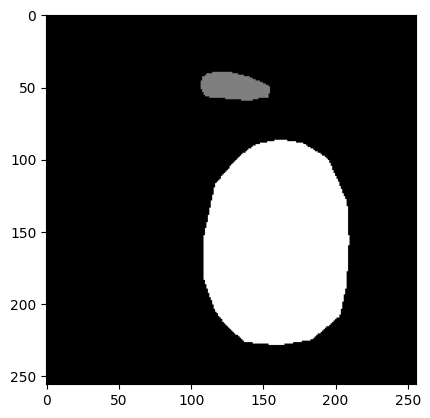

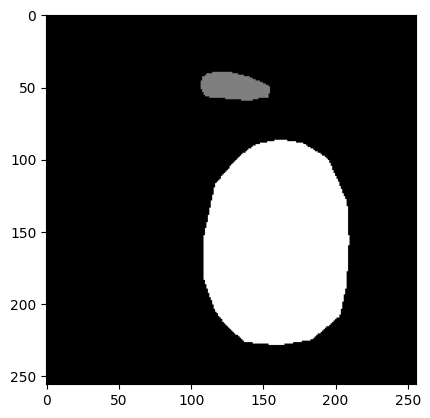

In [2]:
import cv2
import matplotlib.pyplot as plt
mask1 = cv2.imread("/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/00006_PSFHAoP4k_mask.png",0)

mask = cv2.imread("/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/00006_PSFHAoP4k_mask.png",0)  
mask_contour= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)       #  detects boundaries
mask_img = cv2.drawContours(mask,mask_contour[0],0,255, -1)      # draws boundary on an image


img = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)
# Show the image
plt.imshow(img)
plt.show()

img1 = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [3]:
def pad_image_to_square(img):
    if img.dim() == 3:  # For tensors with channels: [C, H, W]
        channels, height, width = img.shape
    elif img.dim() == 2:  # For tensors without channels: [H, W]
        height, width = img.shape
        channels = None
    else:
        raise ValueError("Input tensor must be 2D or 3D")

    # Calculate padding
    if height > width:
        pad_size = (height - width) // 2
        padding = (pad_size, height - width - pad_size, 0, 0)  # Left, right, top, bottom
    elif width > height:
        pad_size = (width - height) // 2
        padding = (0, 0, pad_size, width - height - pad_size)  # Left, right, top, bottom
    else:
        return img  # Already square, no padding needed

    # Apply padding
    padded_img = torch.nn.functional.pad(img.unsqueeze(0), padding, mode="constant", value=0).squeeze(0)
    if channels:
        return padded_img
    else:
        return padded_img.squeeze(0)  # Remove channel dimension if it was 2D

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import os
import pandas as pd
from torchvision.io import read_image
import torch.utils.data as data

class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform, target_transform):
        self.img_path = img_path 
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform

        # Define the mapping of pixel values to class labels
        self.class_mapping = {0: 0, 76: 1, 127: 1, 149: 2, 255: 2}  # Adjust based on your dataset

    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        # Load and process the image
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img_name = os.path.basename(img_path)
        img = pad_image_to_square(img)
        img = img.float() / 255.0
        

        # Load and process the target mask
        if self.target_path:
            mask_path = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])
            mask_name = os.path.basename(mask_path)
            target = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            target = torch.from_numpy(target).long()  # Convert to long tensor
            target = pad_image_to_square(target)

            # Apply mapping to convert pixel values to class labels
            for key, value in self.class_mapping.items():
                target[target == key] = value

            # print(f"Remapped unique values in mask: {torch.unique(target)}")  # Debugging remapped values

            if self.target_transform and len(target.size()) > 1:
                target = self.target_transform(target.unsqueeze(0)).squeeze(0)
        else:
            target = torch.tensor([])

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        return img.float(), target,  img_name, mask_name

# Define the transformation to resize the images to a fixed size
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Use nearest interpolation to preserve class labels in the target masks
transform1 = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST),
])

# Instantiate dataset objects
dataset = CustomDataset(
    img_path='/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane',
    target_path='/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks',
    transform=transform,
    target_transform=transform1
)

test_dataset = CustomDataset(
    img_path='/kaggle/input/unetdata/TN_images/TN_images',
    target_path='/kaggle/input/unetdata/test_Masks/test_Masks',
    transform=transform,
    target_transform=transform1
)

# Check the number of images
img_path = '/kaggle/input/unetdata/denoised_Standard_plane/Standard_plane'
print(len(os.listdir(img_path)))

target_path = '/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks'
print(len(os.listdir(target_path)))

test_img_path = '/kaggle/input/unetdata/TN_images/TN_images'
print(len(os.listdir(test_img_path)))

test_target_path = '/kaggle/input/unetdata/test_Masks/test_Masks'
print(len(os.listdir(test_target_path)))

# Split the dataset into training and validation sets
# train_dataset, val_dataset = data.random_split(dataset, [6067, 1517], generator=torch.Generator().manual_seed(42))

# Create train and validation dataloaders
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

7584
7584
1414
1414


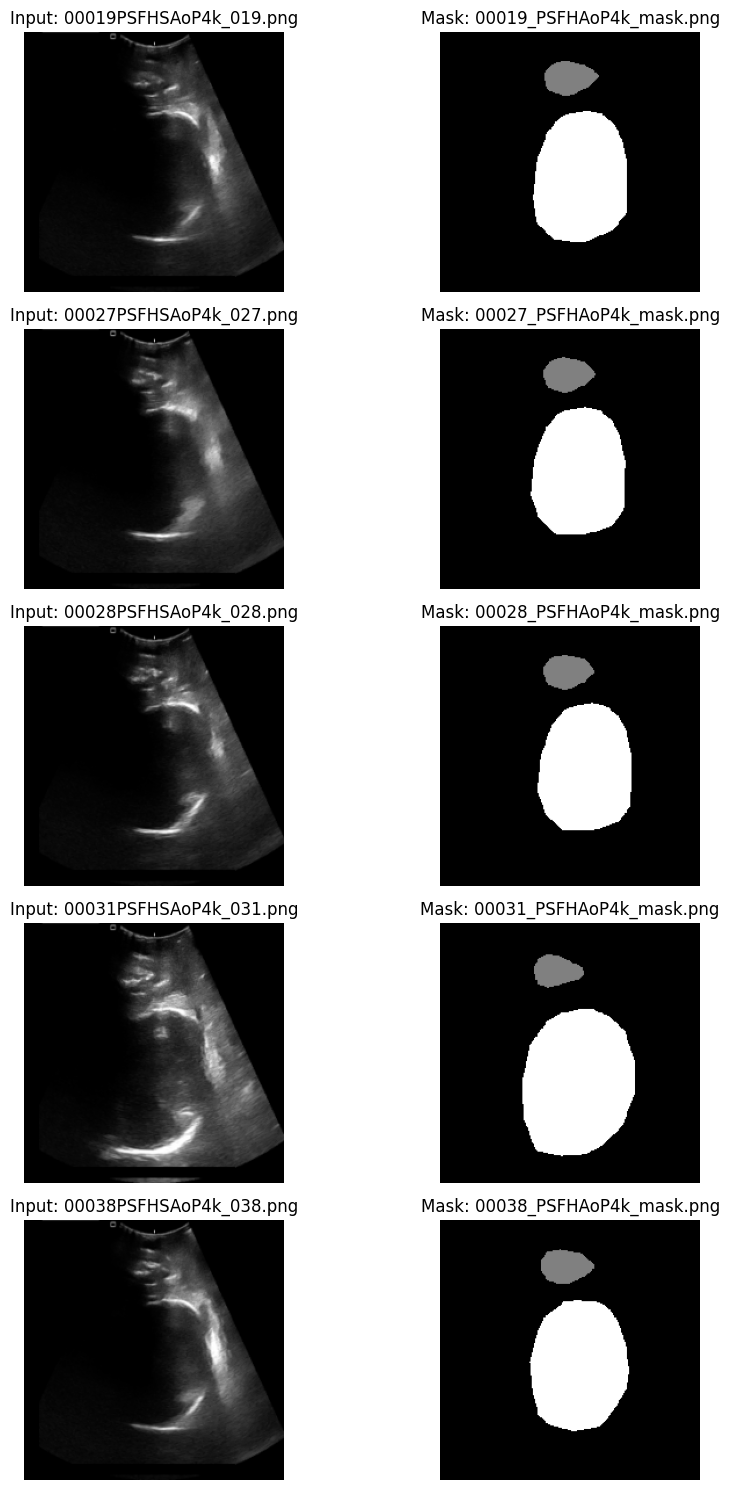

In [5]:
import matplotlib.pyplot as plt
import torch


# Get one batch of data
for i, batch in enumerate(test_dataloader):
    if i == 1:
        break  # Only take the first batch

    # Unpack batch
    images, masks, img_names, mask_names = batch  # images: (batch_size, C, H, W), masks: (batch_size, H, W)

    num_images = min(5, images.shape[0])  # Show up to 5 images

    # Create a figure with 5 rows and 2 columns
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 3))

    for j in range(num_images):
        # Original Image (Column 1)
        axs[j, 0].imshow(images[j, 0].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 0].set_title(f"Input: {img_names[j]}")
        axs[j, 0].axis('off')

        # Corresponding Mask (Column 2)
        axs[j, 1].imshow(masks[j].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 1].set_title(f"Mask: {mask_names[j]}")
        axs[j, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available, running on CPU.")

Using GPU: Tesla T4


In [7]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=3, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [8]:
from torchsummary import summary

if __name__ == "__main__":
    model = UNET(in_channels=1, out_channels=3)
    # Instantiate your model
    # model = Unet(n_classes=3)
    
    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    
    model.to(device)
    print(model)
    
    print(summary(model, input_size=(1, 224,224)))

cuda
UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
   

In [9]:
import torch
torch.cuda.empty_cache()  # Free up unused memory

In [10]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [11]:
for batch in train_dataloader:
        inputs, targets, img_names, mask_names = batch
        print(f"Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
        print(f"Target unique values: {torch.unique(targets)}")
        break

Inputs shape: torch.Size([64, 1, 224, 224]), Targets shape: torch.Size([64, 224, 224])
Target unique values: tensor([0, 1, 2])


In [12]:
import copy


class EarlyStopping:
    def __init__(self, patience, min_delta=0.01, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None  # Initialize best_model to None
        self.best_loss = float('inf')  # Initialize best_loss to a large value
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        # Check if it's the first epoch or if validation loss improved
        if val_loss < self.best_loss:  # Use '<' to check for improvement
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    if self.best_model is not None:  # Check if best_model exists before loading
                        model.load_state_dict(self.best_model)
                    else:
                        print("Warning: No best model found to restore.")
                return True
        return False

In [13]:
def save_checkpoint(model, optimizer, path, epoch, early_stopping, all_train_loss, all_val_loss, all_train_dice,
                   all_val_dice,all_train_dice_wo, all_val_dice_wo, all_train_jaccard,all_val_jaccard, all_train_voe, all_val_voe, all_train_rvd,
                   all_val_rvd):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': early_stopping.best_loss,
        'counter': early_stopping.counter,
        'all_train_loss': all_train_loss,
        'all_val_loss': all_val_loss,
        'all_train_dice': all_train_dice,
        'all_val_dice': all_val_dice,
        'all_train_dice_wo': all_train_dice_wo,
        'all_val_dice_wo': all_val_dice_wo,
        'all_train_jaccard': all_train_jaccard,
        'all_val_jaccard': all_val_jaccard,
        'all_train_voe': all_train_voe,
        'all_val_voe': all_val_voe,
        'all_train_rvd': all_train_rvd,
        'all_val_rvd': all_val_rvd,
    }
    torch.save(checkpoint, path)


def save_best_model(model,path):
    checkpoint = {
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint,path)

In [14]:
# def match_dims_with_pred_mask(groundtruth_mask):
#   # print("Shape of groundtruth_mask before one-hot encoding:", groundtruth_mask.shape)

#   num_classes = 3
#   groundtruth_mask = np.eye(num_classes)[groundtruth_mask]  
#   # print("Shape after one-hot encoding (temporary):", groundtruth_mask.shape)

#   groundtruth_mask = np.moveaxis(groundtruth_mask, -1, 1)  
#   # print("Shape after axis reordering:", groundtruth_mask.shape)
#   return groundtruth_mask


# Dice score: Measures the overlap between the predicted and ground truth masks. A value of 1 indicates perfect overlap.
# The more the better
def dice_coef_without_class(pred_mask,groundtruth_mask):
    pred_mask = np.array(pred_mask)
    # print("pred_mask shape: ",pred_mask.shape)
    groundtruth_mask = np.array(groundtruth_mask)
    # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
    
    smooth = 0.0001
    intersect = np.sum(pred_mask*groundtruth_mask) + smooth
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask) + smooth
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 5)

def dice_coef(pred_masks, groundtruth_masks):
    
    pred_masks = np.array(pred_masks)
    # print("pred_masks shape: ",pred_masks.shape)
    groundtruth_masks = np.array(groundtruth_masks)
    # groundtruth_masks = match_dims_with_pred_mask(groundtruth_masks)

    smooth = 1e-6  # Smoothing value to avoid division by zero
    dice_per_class = []
    num_classes = 3

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        pred_class = (pred_masks == class_idx).astype(np.float32)
        groundtruth_class = (groundtruth_masks == class_idx).astype(np.float32)

        # Calculate Dice for the current class
        intersection = np.sum(pred_class * groundtruth_class, axis=(1, 2))  # Sum over spatial dimensions
        total_sum = np.sum(pred_class, axis=(1, 2)) + np.sum(groundtruth_class, axis=(1, 2))
        dice_class = (2. * intersection + smooth) / (total_sum + smooth)

        # Average Dice across the batch for this class
        dice_per_class.append(np.mean(dice_class))

    # Macro-average Dice (mean across all classes)
    mean_dice = np.mean(dice_per_class)
    return round(mean_dice, 5)

    # smooth = 0.001
    # dice_per_class = torch.zeros(3)
    # for class_id in range(3):
    #     y_pred_class = (pred_masks == class_id).float()
    #     y_true_class = (groundtruth_masks == class_id).float()

    #     intersection = torch.sum(y_pred_class*y_true_class)
    #     dice_per_class[class_id] = (2.0 * intersection + smooth) / (
    #         torch.sum(y_pred_class) + torch.sum(y_true_class)+smooth
    #     )

    # return dice_per_class



# Jaccard Index (IoU): Measures the intersection over the union of the predicted and ground truth masks.
# The more the better
def iou(pred_mask,groundtruth_mask):
    pred_mask = np.array(pred_mask)
    groundtruth_mask = np.array(groundtruth_mask)
    # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
 
    smooth = 0.0001
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = (intersect + smooth) / (union + smooth)  # Calculate per image IoU
    return round(np.mean(iou),5)  # Average IoU across all images in the batch


# Average Surface Distance (ASD): Measures the average distance between the boundary points of the predicted mask and the ground truth mask.
# The less the better


# Volume Overlap Error (VOE): For non-binary masks, VOE can be adapted by considering the sum of pixel values as a "soft overlap"
# Lower values are better.
def voe(pred_mask, gt_mask):
    pred_mask = np.array(pred_mask)
    gt_mask = np.array(gt_mask)
    # gt_mask = match_dims_with_pred_mask(gt_mask)

    smooth = 0.0001
    intersection = np.sum(np.minimum(pred_mask, gt_mask))  # Soft overlap
    union = np.sum(np.maximum(pred_mask, gt_mask))        # Soft union
    voe = 1 - ((intersection+smooth) / (union+smooth))
    return round(voe,5)


# Relative Volume Difference (RVD): RVD is particularly useful for applications where the total volume
# (e.g., of an organ or lesion) is more important than boundary alignment. It captures whether 
# the predicted segmentation overestimates or underestimates the actual volume.
# The range of Relative Volume Difference (RVD) is unbounded and can theoretically span from −∞ to +∞, depending 
# on the degree of overestimation or underestimation of the predicted volume compared to the ground truth volume. 

# Negative RVD (RVD<0):Indicates that the predicted volume is smaller than the ground truth.
# Example: RVD=−0.2 means the predicted volume is 20% smaller.

# Zero RVD (RVD=0): Indicates a perfect match between the predicted and ground truth volumes.

# Positive RVD (RVD>0): Indicates that the predicted volume is larger than the ground truth.
# Example: RVD=0.15 means the predicted volume is 15% larger.

# Lower values are better.

def rvd(pred_mask, gt_mask):
    pred_mask = np.array(pred_mask)
    gt_mask = np.array(gt_mask)
    # gt_mask = match_dims_with_pred_mask(gt_mask)

    smooth = 0.0001
    pred_volume = np.sum(pred_mask)  # Sum of intensities
    gt_volume = np.sum(gt_mask)     # Sum of intensities
    rvd = (pred_volume - gt_volume) / (gt_volume)
    return round(rvd,5)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from dataset import MyDataset
# from model import UNet

# torch.cuda.empty_cache()

import gc
# del inputs , targets , model
gc.collect()



# Define hyperparameters
learning_rate = 0.001
num_epochs = 200
patience = 30
early_stopping = EarlyStopping(patience=patience)
early_stop = False

k_folds = 5
batch_size = 16


def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set the seed globally
set_seed(42)


train_loaders = []
val_loaders = []
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

    print(f"Fold {fold + 1}")
    print("-------")

    # for batch in train_loader:
    #     _, _, img_names, mask_names = batch
    #     print("Train Batch:", img_names)  

    # # Print image names for val_loader
    # print(f"Validation images in Fold {fold + 1}:")
    # for batch in val_loader:
    #     _, _, img_names, mask_names = batch
    #     print("Validation Batch:", img_names)
        
    print(f"Train_loader: {len(train_loaders[fold])}")
    print(f"Val_loader: {len(val_loaders[fold])}")

    if (fold+1) % 5 == 0:
        break

print(len(train_loaders))
print(len(val_loaders))



# Define the U-Net architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNET().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


PATH = "/kaggle/working/checkpoint_1.pth"
outputCheckpoint_path = "/kaggle/outputs/checkpoint_1.pth"

load_PATH = "/kaggle/input/unet_till_epoch_140/pytorch/default/1/checkpoint_1.pth"

bestModel_path = "/kaggle/working/best_model.pth"
output_bestModel_path = "/kaggle/outputs/best_model.pth"


os.makedirs("/kaggle/working", exist_ok=True)
os.makedirs("/kaggle/outputs", exist_ok=True)

# import os
# print(f"File exists: {os.path.exists(load_PATH)}")
# print(f"File size: {os.path.getsize(load_PATH)} bytes")



if (os.path.exists(PATH) and os.path.getsize(PATH) > 0) or (os.path.exists(load_PATH) and os.path.getsize(load_PATH)>0):
    if os.path.exists(load_PATH):
        load_PATH = load_PATH
        print("input LOAD_PATH")
    else:
        load_PATH = PATH
        print("output path")
        
    # checkpoint = torch.load(load_PATH)
    # print(checkpoint['model_state_dict'].keys())
    checkpoint = torch.load(load_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    all_train_loss = checkpoint['all_train_loss']
    all_val_loss = checkpoint['all_val_loss']
    all_train_dice = checkpoint['all_train_dice']
    all_val_dice = checkpoint['all_val_dice']
    all_train_dice_wo = checkpoint['all_train_dice_wo']
    all_val_dice_wo = checkpoint['all_val_dice_wo']
    all_train_jaccard = checkpoint['all_train_jaccard']
    all_val_jaccard = checkpoint['all_val_jaccard']
    all_train_voe = checkpoint['all_train_voe']
    all_val_voe = checkpoint['all_val_voe']
    all_train_rvd = checkpoint['all_train_rvd']
    all_val_rvd = checkpoint['all_val_rvd']

    best_loss = checkpoint['best_loss']
    early_stopping.best_loss = best_loss
    counter = checkpoint['counter']
    early_stopping.counter = counter
    best_model_wts = model.state_dict()
    

    print("Checkpoint loaded successfully!")
    print("counter: ",counter)
    print("best_loss: ",best_loss)
    print("all_train_loss: ",all_train_loss)
    print("all_val_loss: ",all_val_loss)
    print("all train dice: ",all_train_dice)
    print("all val dice: ",all_val_dice)
    print("all train dice wo: ",all_train_dice_wo)
    print("all val dice wo: ",all_val_dice_wo)
    print("all train jaccard: ",all_train_jaccard)
    print("all val jaccard: ",all_val_jaccard)
    print('all train voe: ',all_train_voe)
    print('all val voe: ',all_val_voe)
    print('all train rvd: ',all_train_rvd)
    print('all val rvd: ',all_val_rvd)
    # print("model state dict:\n",model.load_state_dict(checkpoint['model_state_dict']).keys())
    start_epoch += 1
else:
    print("Checkpoint file is empty or missing. Initializing variables.")
    start_epoch = 0
    best_loss = 1e5
    best_model_wts = 0
    all_train_loss, all_val_loss = [], []
    all_train_dice, all_val_dice = [], []
    all_train_dice_wo, all_val_dice_wo = [], []
    all_train_jaccard, all_val_jaccard = [], []
    all_train_voe, all_val_voe = [], []
    all_train_rvd, all_val_rvd = [],[]



print("start_epoch: ",start_epoch)
# Train the U-Net
for epoch in range(start_epoch,num_epochs):
  print("-------epoch: ",epoch)

  fold = epoch % 5
  print("processing fold: ",fold)
  model.train()

#   train_loss = []
#   # train_dice = []
#   true = []
#   pre = []
#   data_iter = iter(train_loaders[fold])
#   inputs, targets, img_names, mask_names = next(data_iter)
#   # print(img_names)
#   # print(mask_names)
    
#   # Forward pass
#   inputs = inputs.to(device)   #
#   targets = targets.to(device)#

#   outputs = model(inputs)
#   loss = criterion(outputs, targets)

#   # Backward pass
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()

#   preds = torch.argmax(outputs, dim=1)

#   true.extend(targets.cpu().numpy())
#   pre.extend(preds.detach().cpu().numpy())

#   train_loss.append(loss.item()) 
# # train_dice.append(dice_score(preds, targets))


#   all_train_loss.append(np.mean(train_loss))
#   train_dice = dice_coef(pre,true)
#   all_train_dice.append(train_dice)
#   train_iou = iou(pre,true)
#   all_train_jaccard.append(train_iou)
#   train_voe = voe(pre,true)
#   all_train_voe.append(train_voe)
#   train_rvd = rvd(pre,true)
#   all_train_rvd.append(train_rvd)

#   print(f"Epoch [{epoch+1}/{num_epochs}], train Loss: {np.mean(train_loss):.4f}, train dice: {train_dice}, train jaccard: {train_iou}, train voe: {train_voe}, train rvd: {train_rvd}")


#   with torch.no_grad():
#     model.eval()
#     val_loss = []
#     val_true = []
#     val_pre = []
      
#     val_data_iter = iter(val_loaders[fold])
#     inputs, targets, img_names, mask_names = next(val_data_iter)

#     # print(img_names)
#     # print(mask_names)
        
#     inputs = inputs.to(device)
#     targets = targets.to(device)

#     outputs = model(inputs)
#     loss = criterion(outputs,targets)

#     preds = torch.argmax(outputs, dim=1)

#     val_true.extend(targets.cpu().numpy())
#     val_pre.extend(preds.detach().cpu().numpy())

#     val_loss.append(loss.item())
        
        
  
    
#   all_val_loss.append(np.mean(val_loss))
#   val_dice = dice_coef(val_pre,val_true)
#   all_val_dice.append(val_dice)
#   val_iou = iou(val_pre,val_true)
#   all_val_jaccard.append(val_iou)
#   val_voe = voe(val_pre,val_true)
#   all_val_voe.append(val_voe)
#   val_rvd = rvd(val_pre,val_true)
#   all_val_rvd.append(val_rvd)


#   if np.mean(val_loss) < best_loss:
#         # best_acc = val_accuracy
#         best_loss = np.mean(val_loss)
#         #Save the best model
#         best_model_wts = model.state_dict()
#         torch.save(best_model_wts, bestModel_path)
#         save_best_model(model,output_bestModel_path)
#         print(f"New best model saved with validation loss: {best_loss:.4f}")


#   optimizer.param_groups[0]['lr'] *= 0.9
#   early_stop = early_stopping(model, np.mean(val_loss))
#   print(early_stopping.status)

#   if early_stop:
#      print(f"Early stopping at epoch {epoch + 1}")
#      break
      
#   # Print the loss for the current epoch
#   print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {np.mean(val_loss):.4f}, val dice: {val_dice}, val jaccard: {val_iou}, val voe: {val_voe}, val rvd: {val_rvd}")

    
  train_loss = []
  # train_dice = []
  true = []
  pre = []
  # print("TRAINING:")
  for batch in train_loaders[fold]:
      inputs, targets, img_names, mask_names = batch
      # print("batch_id: ",batch_id)
      # print("each_batch_size: ",len(batch))
      # print(img_names)
      # print(mask_names)
    
      # Forward pass
      inputs = inputs.to(device)   #
      targets = targets.to(device)#

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      preds = torch.argmax(outputs, dim=1)

      true.extend(targets.cpu().numpy())
      pre.extend(preds.detach().cpu().numpy())

      train_loss.append(loss.item())
      # train_dice.append(dice_score(preds, targets))


  all_train_loss.append(np.mean(train_loss))
  train_dice = dice_coef(pre,true)
  all_train_dice.append(train_dice)
  train_dice_wo = dice_coef_without_class(pre,true)
  all_train_dice_wo.append(train_dice_wo)
  train_iou = iou(pre,true)
  all_train_jaccard.append(train_iou)
  train_voe = voe(pre,true)
  all_train_voe.append(train_voe)
  train_rvd = rvd(pre,true)
  all_train_rvd.append(train_rvd)

  print(f"Epoch [{epoch+1}/{num_epochs}], train Loss: {np.mean(train_loss):.4f}, train dice: {train_dice}, train_dice_wo: {train_dice_wo}, train jaccard: {train_iou}, train voe: {train_voe}, train rvd: {train_rvd}")

  # Evaluate the U-Net on the validation set
  with torch.no_grad():
    model.eval()
    val_loss = []
    val_true = []
    val_pre = []
    # print("VALIDATING")
      
    for batch in val_loaders[fold]:
        inputs, targets, img_names, mask_names = batch
        # print("batch_id: ",val_batch_id)
        # print("each_batch_size: ",len(batch))
        # val_batch_id+=1
        # print(img_names)
        # print(mask_names)
        
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs,targets)

        preds = torch.argmax(outputs, dim=1)

        val_true.extend(targets.cpu().numpy())
        val_pre.extend(preds.detach().cpu().numpy())

        val_loss.append(loss.item())
        
        
  
    
  all_val_loss.append(np.mean(val_loss))
  val_dice = dice_coef(val_pre,val_true)
  all_val_dice.append(val_dice)
  val_dice_wo = dice_coef_without_class(val_pre,val_true)
  all_val_dice_wo.append(val_dice_wo)
  val_iou = iou(val_pre,val_true)
  all_val_jaccard.append(val_iou)
  val_voe = voe(val_pre,val_true)
  all_val_voe.append(val_voe)
  val_rvd = rvd(val_pre,val_true)
  all_val_rvd.append(val_rvd)


  if np.mean(val_loss) < best_loss:
        # best_acc = val_accuracy
        best_loss = np.mean(val_loss)
        #Save the best model
        best_model_wts = model.state_dict()
        torch.save(best_model_wts, bestModel_path)
        save_best_model(model,output_bestModel_path)
        print(f"New best model saved with validation loss: {best_loss:.4f}")


  scheduler.step(np.mean(val_loss))
  early_stop = early_stopping(model, np.mean(val_loss))
  print(early_stopping.status)

  if early_stop:
     print(f"Early stopping at epoch {epoch + 1}")
     break
      
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {np.mean(val_loss):.4f}, val dice: {val_dice}, val_dice_wo: {val_dice_wo}, val jaccard: {val_iou}, val voe: {val_voe}, val rvd: {val_rvd}")
    
  save_checkpoint(model, optimizer, PATH, epoch, early_stopping=early_stopping, all_train_loss=all_train_loss, all_val_loss=all_val_loss,
                  all_train_dice=all_train_dice, all_val_dice=all_val_dice, all_train_dice_wo = all_train_dice_wo, all_val_dice_wo = all_val_dice_wo,
                  all_train_jaccard=all_train_jaccard, all_val_jaccard=all_val_jaccard, all_train_voe=all_train_voe, all_val_voe=all_val_voe, 
                  all_train_rvd=all_train_rvd, all_val_rvd=all_val_rvd)
    
  save_checkpoint(model, optimizer, outputCheckpoint_path, epoch, early_stopping=early_stopping, all_train_loss=all_train_loss,all_val_loss=all_val_loss,
                 all_train_dice=all_train_dice, all_val_dice=all_val_dice, all_train_dice_wo = all_train_dice_wo, all_val_dice_wo = all_val_dice_wo,
                 all_train_jaccard=all_train_jaccard, all_val_jaccard=all_val_jaccard, all_train_voe=all_train_voe, all_val_voe=all_val_voe, 
                 all_train_rvd=all_train_rvd, all_val_rvd=all_val_rvd)
    
  print("checkpoint saved successfully")
  # torch.save(model.state_dict(),outputModel_path)

Fold 1
-------
Train_loader: 380
Val_loader: 95
Fold 2
-------
Train_loader: 380
Val_loader: 95
Fold 3
-------
Train_loader: 380
Val_loader: 95
Fold 4
-------
Train_loader: 380
Val_loader: 95
Fold 5
-------
Train_loader: 380
Val_loader: 95
5
5
cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-15-b4459bf769da>:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of 

input LOAD_PATH
Checkpoint loaded successfully!
counter:  0
best_loss:  0.0011254639805931793
all_train_loss:  [0.1383534765655273, 0.05864670439378211, 0.04490142359251254, 0.04006125746098788, 0.03700717938083567, 0.034949544003527414, 0.032793163851295645, 0.031141248536541273, 0.030139360410210335, 0.02860057003011829, 0.028190627574038347, 0.027056872751563786, 0.0256591261585096, 0.026226747138915877, 0.02550030566849991, 0.023172955540940166, 0.022636160274085246, 0.02188398498355558, 0.020501980893804055, 0.01983312338737673, 0.01932179890573025, 0.018723962857927146, 0.01822890618717984, 0.01730224751916371, 0.016174485093276753, 0.015787659681059028, 0.015190748669403164, 0.014597705849691441, 0.014102211333566199, 0.013189861582788197, 0.013842317932530454, 0.013061480934878713, 0.012311065453104675, 0.011519917367810481, 0.011557737610449917, 0.011023709370362523, 0.010879811117621629, 0.010956998702481782, 0.010284524580071631, 0.010204343660734593, 0.009392980312144287, 0

Text(0, 0.5, 'loss')

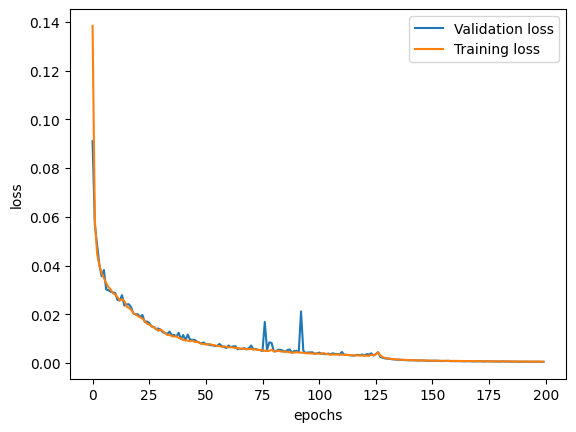

In [16]:
import matplotlib.pyplot as plt
plt.plot(all_val_loss)
plt.plot(all_train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

In [17]:
import os
import numpy as np
from PIL import Image

# From the best model

model_weight_path = '/kaggle/input/unet_till_epoch_140/pytorch/default/1/best_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNET().to(device)

model.load_state_dict(torch.load(model_weight_path))
print(model.load_state_dict(torch.load(model_weight_path)))

model.eval()


# Create an output directory for predicted masks
output_dir_work = "/kaggle/working/predicted_masks"
os.makedirs(output_dir_work, exist_ok=True)

output_dir = "/kaggle/outputs/predicted_images/"
os.makedirs(output_dir, exist_ok=True)

# Mapping dictionary
value_mapping = {0: 0, 1: 127, 2: 255}

with torch.no_grad():
    test_loss = []
    test_msk = []
    test_pred_msk = []
    test_img = []
    all_image_names = []
    all_mask_names = []
      
    for batch in test_dataloader:
        test_images, test_masks, img_names, mask_names = batch
        
        test_images = test_images.to(device)
        test_masks = test_masks.to(device)

        predicted_masks = model(test_images)
        predicted_masks = torch.argmax(predicted_masks, dim=1)

        # predicted_masks = model(test_images)
        # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

        test_img.extend(test_images.cpu().numpy())
        test_msk.extend(test_masks.cpu().numpy())
        test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

        all_image_names.extend(img_names)
        all_mask_names.extend(mask_names)

        # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
        for i in range(predicted_masks.shape[0]):
            pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
            # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
            pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
            # print(mask_names[i])
            pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
            pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)
            pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)

print(f"Saved predicted masks in: {output_dir}")


    
    # batch = next(iter(test_dataloader))
    # test_images, test_masks, img_names, mask_names = batch
        
    # test_images = test_images.to(device)
    # test_masks = test_masks.to(device)

    # predicted_masks = model(test_images)
    # predicted_masks = torch.argmax(predicted_masks, dim=1)

    # test_img.extend(test_images.cpu().numpy())
    # test_msk.extend(test_masks.cpu().numpy())
    # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

    # all_image_names.extend(img_names)
    # all_mask_names.extend(mask_names)
  
    
test_dice = dice_coef(test_pred_msk,test_msk)
test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
test_iou = iou(test_pred_msk,test_msk)
test_voe = voe(test_pred_msk,test_msk)
test_rvd = rvd(test_pred_msk,test_msk)
      
# Print the loss for the current epoch
print(len(all_mask_names))
print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

cuda


<ipython-input-17-cfd4d3d4784a>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weight_path))
<ipython-input-17-cfd4d3d4784a>:14: Fu

<All keys matched successfully>
Saved predicted masks in: /kaggle/outputs/predicted_images/
1414
test dice: 0.9540, test dice wo: 1.88037, test jaccard: 15.71827, test voe: 0.06293, test rvd: -0.03447


In [18]:
# till epoch 40
# test dice: 0.9493, test dice wo: 1.86965, test jaccard: 14.34307, test voe: 0.07375, test rvd: -0.03797

# till epoch 100
# test dice: 0.9511, test dice wo: 1.87336, test jaccard: 14.79234, test voe: 0.06959, test rvd: -0.04125

# till epoch 140
# test dice: 0.9540, test dice wo: 1.88037, test jaccard: 15.71827, test voe: 0.06293, test rvd: -0.03447

In [19]:
def relative_volume_difference(y_pred, y_true):
    rvd_list = []
    n_classes = 3
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the volumes (i.e., the sum of non-zero pixels)
        V_pred = torch.sum(y_pred_class)
        V_gt = torch.sum(y_true_class)
        
        # Calculate RVD for this class
        if V_gt != 0:
            rvd = torch.abs(V_pred - V_gt) / V_gt
        else:
            rvd = 0  # If the ground truth volume is zero, set RVD to zero (or some other default)
        
        rvd_list.append(rvd)
    
    # Return the mean RVD across all classes
    return torch.mean(torch.tensor(rvd_list))

# Volume Overlap Error (VOE) for multiclass segmentation
def volume_overlap_error(y_pred, y_true):
    voe_list = []
    n_classes = 3
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the intersection and union
        intersection = torch.sum(y_pred_class * y_true_class)
        union = torch.sum(torch.max(y_pred_class, y_true_class))
        
        # Calculate VOE for this class
        if union != 0:
            voe = (union - intersection) / union
        else:
            voe = 0  # If the union is zero, set VOE to zero (or some other default)
        
        voe_list.append(voe)
    
    # Return the mean VOE across all classes
    return torch.mean(torch.tensor(voe_list))

In [20]:
import torch
from torchmetrics import JaccardIndex, Dice

n_classes = 3

# IoU (Jaccard Index) metric
iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# Dice Score metric (also called F1 Score for segmentation)
dice_metric = Dice(num_classes=n_classes, average='macro')

# Convert ground truth and prediction to PyTorch tensors
y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# Ensure tensors are on the same device (important for GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_test_tensor = y_test_tensor.to(device)
y_pred_tensor = y_pred_tensor.to(device)

iou_metric = iou_metric.to(device)
dice_metric = dice_metric.to(device)

# Compute IoU
mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
print("Mean IoU =", mean_iou.item())

# Compute Dice Score
dice_score = dice_metric(y_pred_tensor, y_test_tensor)
print("Dice Score =", dice_score.item())

rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
print("Relative Volume Difference (RVD) =", rvd.item())

voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
print("Volume Overlap Error (VOE) =", voe.item())


<ipython-input-20-82bc9dfdfe58>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)


Mean IoU = 0.9304126501083374
Dice Score = 0.9631674885749817
Relative Volume Difference (RVD) = 0.019947031512856483
Volume Overlap Error (VOE) = 0.06958738714456558


In [21]:
# till epoch 40
# Mean IoU = 0.9210425615310669
# Dice Score = 0.9579306840896606
# Relative Volume Difference (RVD) = 0.015674658119678497
# Volume Overlap Error (VOE) = 0.07895743101835251


# till epoch 100
# Mean IoU = 0.9248627424240112
# Dice Score = 0.9600796699523926
# Relative Volume Difference (RVD) = 0.022811101749539375
# Volume Overlap Error (VOE) = 0.0751371756196022

# till epoch 140
# Mean IoU = 0.9304126501083374
# Dice Score = 0.9631674885749817
# Relative Volume Difference (RVD) = 0.019947031512856483
# Volume Overlap Error (VOE) = 0.06958738714456558

1414
00019PSFHSAoP4k_019.png
00019_PSFHAoP4k_mask.png
00027PSFHSAoP4k_027.png
00027_PSFHAoP4k_mask.png
00028PSFHSAoP4k_028.png
00028_PSFHAoP4k_mask.png
00031PSFHSAoP4k_031.png
00031_PSFHAoP4k_mask.png
00038PSFHSAoP4k_038.png
00038_PSFHAoP4k_mask.png


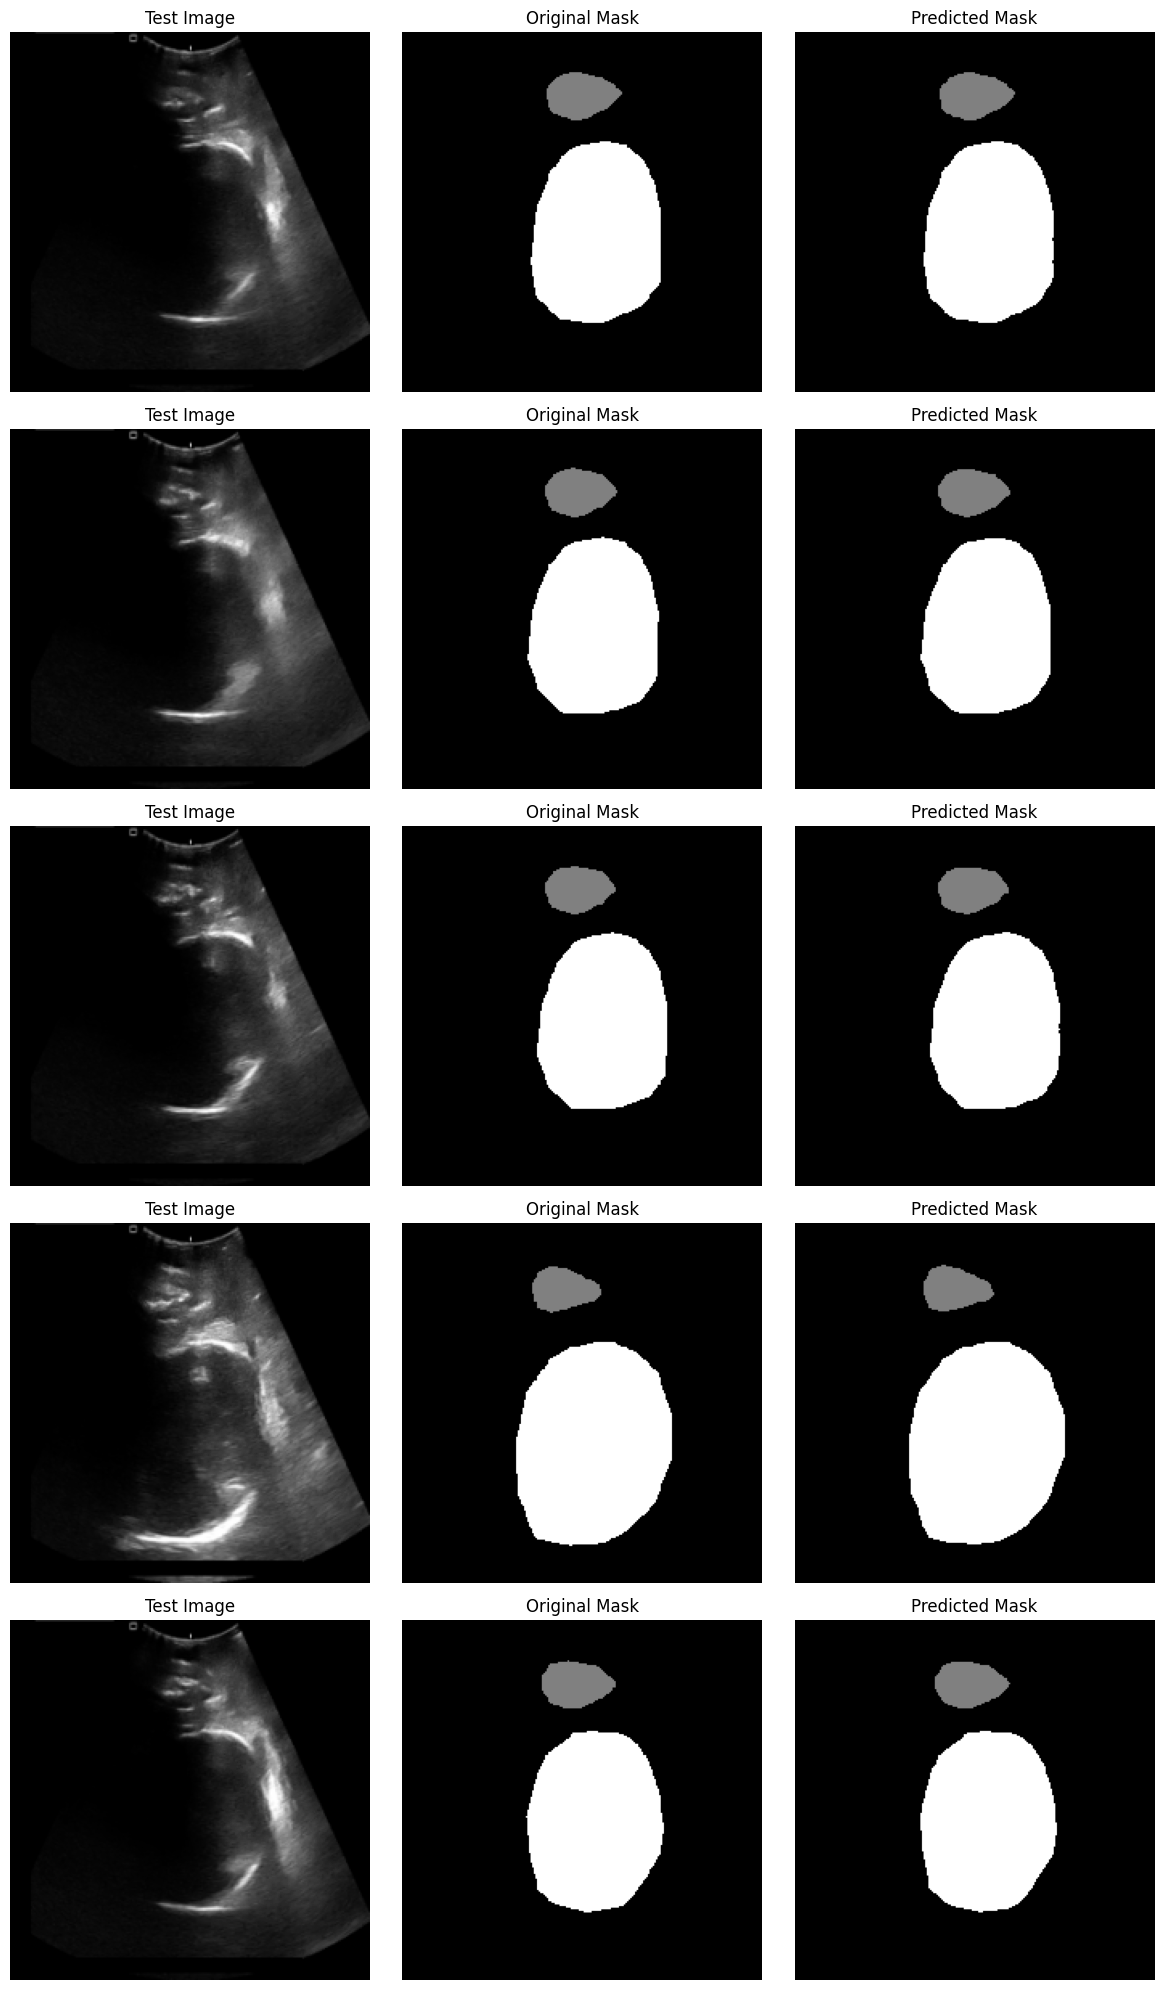

In [22]:
import cv2

test_img = np.array(test_img)
test_msk = np.array(test_msk)
test_pred_msk = np.array(test_pred_msk)

num_images = min(5, test_img.shape[0])  # Show up to 5 images
print(test_img.shape[0])

# Plot original image, ground truth mask, and predicted mask side by side
fig, axs = plt.subplots(nrows=num_images, ncols=3, figsize=(12, num_images * 4))

for i in range(num_images):
    print(all_image_names[i])
    print(all_mask_names[i])
    # Original Image
    axs[i, 0].imshow(test_img[i, 0], cmap='gray')  # Assuming grayscale images
    axs[i, 0].set_title("Test Image")
    axs[i, 0].axis("off")

    # Ground Truth Mask
    axs[i, 1].imshow(test_msk[i], cmap='gray')  # Ground truth masks with class labels
    axs[i, 1].set_title("Original Mask")
    axs[i, 1].axis("off")

    # Model-Predicted Mask
    axs[i, 2].imshow(test_pred_msk[i], cmap='gray')  # Predicted masks with class labels
    axs[i, 2].set_title("Predicted Mask")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [23]:
# import cv2

# test_img = np.array(test_img)
# test_msk = np.array(test_msk)
# test_pred_msk = np.array(test_pred_msk)

# output_dir_work = "/kaggle/working/predicted_images/"
# os.makedirs(output_dir_work, exist_ok=True)

# output_dir = "/kaggle/outputs/predicted_images/"
# os.makedirs(output_dir, exist_ok=True)

# num_images = test_img.shape[0] 

# for i in range(num_images):
#     # Use the original mask name for naming
#     original_name = all_mask_names[i]  # Use the original mask name
#     base_name = os.path.splitext(original_name)[0]  # Get the base name without extension

#     # Save the predicted mask using matplotlib
#     plt.figure(figsize=(8, 8))
#     plt.imshow(test_pred_msk[i], cmap="gray")  # Display as grayscale
#     plt.axis("off")  # Turn off axes for a clean image

#     output_path = os.path.join(output_dir_work, f"{base_name}_predicted.png")
#     plt.savefig(output_path, bbox_inches="tight", pad_inches=0)  # Save without extra margins
#     plt.close()

#     output_path = os.path.join(output_dir, f"{base_name}_predicted.png")
#     plt.savefig(output_path, bbox_inches="tight", pad_inches=0)  # Save without extra margins
#     plt.close()
    

#     if ((i+1)%100==0):
#         print(i+1," images done")